# $\mathcal{l}_2$ penalty method algorithm

In [1]:
# References

# norms_sqrd(S,X) - max(norms_sqrd(S,X))

# beta = max(norms_sqrd)

# V = s_x_list_norms(S,X)**2 - max(s_x_list_norms(S,X)**2)
# max(0,V[5])

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time

In [3]:
FIELDSIZE = 100
SCALE = 100

In [4]:
S = np.array([random.random()*SCALE, random.random()*SCALE])
X = np.array([ [ random.random()*SCALE, random.random()*SCALE ] for i in range(FIELDSIZE) ])

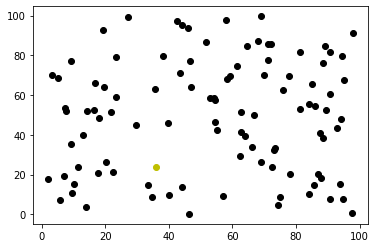

In [5]:
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.scatter(x0,x1, c = 'k')
plt.scatter(S[0], S[1], c = 'y')
plt.show()

In [6]:
def s_x_list(s,x):
    arr1 = []
    for i in range(FIELDSIZE):
        t1 = s - x[i]
        arr1.append(t1)
    return np.array(arr1)

In [7]:
def norms_sqrd(s,x):
    arr1 = []
    for i in range(FIELDSIZE):
        t1 = s - x[i]
        t2 = np.array(t1)
        t3 = np.linalg.norm(t2)**2
        arr1.append(t3)
    return np.array(arr1)

In [8]:
def gradient_function(s,x,k,b):
    N = norms_sqrd(s,x)
    s_minus_x = s_x_list(s,x)
    g_max = []
    if  max(norms_sqrd(s,x)) < b: #update beta if its closer
        b = max(norms_sqrd(s,x))
    for i in range(FIELDSIZE):
        g = N[i] - b
        g_plus = max(0,g)
        g_max.append(s_minus_x[i]*g_plus)
    grad = 2*sum(s_minus_x) + 2*(k**2)*sum(g_max)
    return grad

In [9]:
def GD(s,x,k,b, step): return s - step*gradient_function(s,x,k,b)

In [10]:
def Descent(s,x, EPSILON):
    s0 = s
#     print('s', s0)
    k=1
    beta = max(norms_sqrd(s0,x))
#     print("beta", beta)
    s_list = [s0]
    lam = 1 / np.max( np.linalg.svd( x @ x.T ) [1] ) # approximating Lipschitz constant with SVD (MATLAB ok)
    theta = float(random.getrandbits(128)) # this should essentially be infinity
#     print('lambda', lam)
    s1 = GD(s0,x,k,beta,lam)
#     print('s', s1)
    s_list.append(s1)
    norm_list = [np.linalg.norm(gradient_function(s1,x,k,beta))]
    
    k=2
    while np.linalg.norm(gradient_function(s1,x,k,beta)) > EPSILON:
#         print("point distance", np.linalg.norm(s1 - s0))
#         if max(norms_sqrd(s1,x)) < beta:
#             beta = max(norms_sqrd(s1,x))
#         print("beta", beta)
        old_lam = lam
        min1 = np.sqrt(1 + theta)*old_lam
#         print("min1", min1)
        min2 = np.linalg.norm(s1-s0)/(2*np.linalg.norm(gradient_function(s1, x, k, beta) - gradient_function(s0, x, k, beta) ))
#         print("min2", min2)
        lam = np.min([min1, min2])
#         print('lambda', lam)
        theta = lam/old_lam
        s0 = s1
        s1 = GD(s0, x, k, beta, lam )
#         print('s', s1)
        s_list.append(s1)
        norm_list.append(np.linalg.norm(gradient_function(s1,x,k,beta)))
        k+=1
    return np.array([s_list, norm_list])

In [11]:
TEST = Descent(S,X,1e-6)

<ipython-input-10-a72f219129ba>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list, norm_list])


In [12]:
len(TEST[1])

34

In [13]:
test0 = [TEST[0][i][0] for i in range(len(TEST[0]))]
test1 = [TEST[0][i][1] for i in range(len(TEST[0]))]

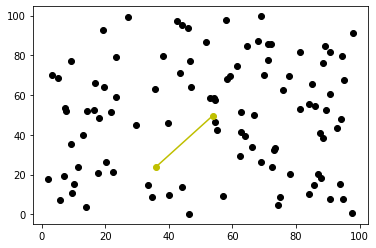

In [14]:
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.scatter(x0,x1, c = 'k')
plt.scatter(test0[0], test1[1], c = 'y')
plt.plot(test0, test1, c = 'y')
plt.scatter(test0[-1], test1[-1], c = 'y')
plt.show()